# Recruit Restaurant Visitor Forecasting

## 問題定義

Recruit Holdings運営の「AirREGI」の予約サイトを利用してレストランに予約、または実際にレストランに来店した人数のデータセットをもとに、機械学習によって、ある期間に訪れるであろう顧客人数を予測するタスクになります。参考に日本では有名ばもう一つのレストラン予約レヴューサイト「Hot Pepper Gourmet」の同様なデーセットも用意されています。
ですので今回は時系列データを扱うコンペになります。

# データセットの用意

In [1]:
# 各ライブラリのインストール
import numpy as np
import pandas as pd
from sklearn import preprocessing
from datetime import date, timedelta
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Data wrangling brought to you by the1owl
# https://www.kaggle.com/the1owl/surprise-me

データセットのcsvファイルの一覧を表示します。

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
file_list = check_output(["ls", "../input"]).decode("utf8")
file_list = file_list.strip().split('\n')

air_reserve.csv
air_store_info.csv
air_visit_data.csv
date_info.csv
hpg_reserve.csv
hpg_store_info.csv
sample_submission.csv
store_id_relation.csv



In [3]:
# データセットを一つの辞書配列にまとめる
data = {
    'tra':
    pd.read_csv('../input/air_visit_data.csv'),
    'as':
    pd.read_csv('../input/air_store_info.csv'),
    'hs':
    pd.read_csv('../input/hpg_store_info.csv'),
    'ar':
    pd.read_csv('../input/air_reserve.csv'),
    'hr':
    pd.read_csv('../input/hpg_reserve.csv'),
    'id':
    pd.read_csv('../input/store_id_relation.csv'),
    'tes':
    pd.read_csv('../input/sample_submission.csv'),
    'hol':
    pd.read_csv('../input/date_info.csv').rename(columns={
        'calendar_date': 'visit_date'
    })}

# EDA

各データセットの中身について把握していきます。  
それぞれのshape、データ容量、各カラムのデータ型、欠損値の有無、そしてheadで先頭５行分を表示します。その結果、欠損値はなく、１ファイル内の特徴量が少ないことがわかります。

In [4]:
for file in file_list:
    
    var_name = file.rstrip('.csv')
    print(file)
    df = pd.read_csv('../input/'+file)
    df.head()
    print('Shape:',df.shape)
    print('Size: {:5.2f} MB'.format(df.memory_usage().sum()/1024**2))
    tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values'}))
    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
    display(tab_info)
    display(df[:5])

air_reserve.csv
Shape: (92378, 4)
Size:  2.82 MB


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
column type,object,object,object,int64
null values,0,0,0,0
null values (%),0,0,0,0


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


air_store_info.csv
Shape: (829, 5)
Size:  0.03 MB


,air_store_id,air_genre_name,air_area_name,latitude,longitude
column type,object,object,object,float64,float64
null values,0,0,0,0,0
null values (%),0,0,0,0,0


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


air_visit_data.csv
Shape: (252108, 3)
Size:  5.77 MB


,air_store_id,visit_date,visitors
column type,object,object,int64
null values,0,0,0
null values (%),0,0,0


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


date_info.csv
Shape: (517, 3)
Size:  0.01 MB


,calendar_date,day_of_week,holiday_flg
column type,object,object,int64
null values,0,0,0
null values (%),0,0,0


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


hpg_reserve.csv
Shape: (2000320, 4)
Size: 61.04 MB


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
column type,object,object,object,int64
null values,0,0,0,0
null values (%),0,0,0,0


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


hpg_store_info.csv
Shape: (4690, 5)
Size:  0.18 MB


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
column type,object,object,object,float64,float64
null values,0,0,0,0,0
null values (%),0,0,0,0,0


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


sample_submission.csv
Shape: (32019, 2)
Size:  0.49 MB


,id,visitors
column type,object,int64
null values,0,0
null values (%),0,0


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


store_id_relation.csv
Shape: (150, 2)
Size:  0.00 MB


,air_store_id,hpg_store_id
column type,object,object
null values,0,0
null values (%),0,0


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


まず、訪問者数と、訪問者数をlog変換した値をそれぞれのヒストグラムをsubplotで表示します。  
全店舗での訪問者数の傾向が把握できます。

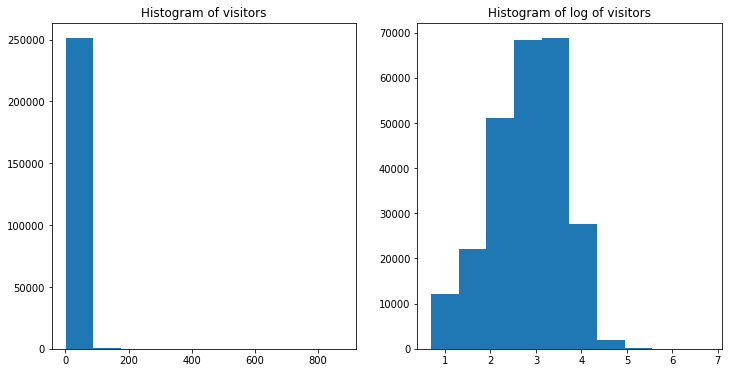

In [5]:
plt.subplots(figsize=(12,6))
plt.subplot(1,2,1)
data['tra']['visitors'].hist()
plt.title('Histogram of visitors')
plt.grid(False)

plt.subplot(1,2,2)
plt.title('Histogram of log of visitors')
data['tra']['visitors'].map(pd.np.log1p).hist()
plt.grid(False)

# 前処理の実装と説明

### データセットdf['ar'],df['hr']をそれぞれ作成

In [6]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    print( df+' :',data[df].head())


ar :            air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                      0                 2
1  air_00a91d42b08b08d9  2016-12-05                      4                 9
2  air_00a91d42b08b08d9  2016-12-14                      6                18
3  air_00a91d42b08b08d9  2016-12-17                      6                 2
4  air_00a91d42b08b08d9  2016-12-20                      2                 4
hr :            air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-01-14                      3                 2
1  air_00a91d42b08b08d9  2016-01-15                      6                 4
2  air_00a91d42b08b08d9  2016-01-16                      3                 2
3  air_00a91d42b08b08d9  2016-01-22                      3                 2
4  air_00a91d42b08b08d9  2016-01-29                      6                 5


In [7]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
# 曜日を数値に変換
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
# yearを分割しをyearカラム作成
data['tra']['year'] = data['tra']['visit_date'].dt.year
# 月、日も分割
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['day'] = data['tra']['visit_date'].dt.day
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month,day
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,13
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,14
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,15
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,16
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,18


In [8]:
 # sumple_submissionの'id'から'日付を分割しvisit_date'カラム作成
data['tes']['visit_date'] = data['tes']['id'].map( lambda x: str(x).split('_')[2])
data['tes'].head()

,id,visitors,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27


In [9]:
 # sumple_submissionの'id'から'日付を分割し'air_store_idカラム作成
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2])) 

In [10]:
# visit_dateをタイムスタンプに変換
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
 # 曜日を数値に変換しdowカラム作成
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
 # 以下は'visit_date'からyear,month ,dayカラムを作成している
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['day'] = data['tes']['visit_date'].dt.day
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month,day
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,23
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,24
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,25
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,26
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,27


In [11]:
# air_store_idでユニークなデータをunique_storesに格納
unique_stores = data['tes']['air_store_id'].unique()
#   'air_store_id''dow'のカラムからなるデータフレームを作成
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)
stores.head()

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0


'air_store_id', 'dow'でグルーピングしvisitorsの最小値をカラム'visitors'から'min_visitors'に変更して並べる

In [12]:
#sure it can be compressed...
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })

stores, tmpをマージし、'air_store_id'と曜日でグルーピングし'visitors'の平均値を計算し、'mean_visitors'カラム作成。

In [13]:
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })

同様に、'air_store_id'と曜日でグルーピングし'visitors'の中間値を'median_visitors'カラムに格納。

In [14]:
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })

同様に、'air_store_id' と曜日でグルーピングし'visitors'の最大値を''max_visitors''カラムに格納。

In [15]:
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })

同様に、'air_store_id' と曜日でグルーピングし'visitors'の総和を'count_observations'カラムに格納。

In [16]:
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
# storesと data['as']をマージ
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


 preprocessing.LabelEncoderでstoresの'air_genre_name' と'air_area_name'の文字データを離散の数値に変換

In [17]:
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])
# data['hol']の'visit_date'をタイムスタンプ型に変換 
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
# data['hol']の'day_of_week'を離散の数値に変換
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])

#  data['hol']の'visit_date'をdate型に変換
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [18]:
# data['tra'] とdata['hol']をマージしてtrainデータに
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
# data['tes'] とdata['hol']をマージしてtestデータに
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])
#data['tra']とstoresをマージしてtrainデータに
train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
# data['tes'] と storesをマージしてtestデータに
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

data['ar'], data['hr']をそれぞれtrain,testにそれぞれマージする

In [19]:
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

In [20]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
# 欠損地には-1を代入
train = train.fillna(-1)
test = test.fillna(-1)

print('Binding to float32')

Binding to float32


In [21]:
#trainのデータ型をfloat32に統一
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
#testのデータ型をfloat32に統一
for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

# trainを日付順に昇順でソート
train=train.sort_values(by=["visit_date"], ascending=True)

train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1).copy()
train_y = np.log1p(train['visitors'].values)

print('train_x.shape :',str(train_x.shape)+'  '+'train_y.shape :',str(train_y.shape))

test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1).copy()
print('train_x.shape :',str(test_x.shape))

train_x.shape : (252108, 17)  train_y.shape : (252108,)
train_x.shape : (32019, 17)


# 評価関数について、なぜ数ある評価関数からこの評価関数を選択しているか考察せよ

${ \displaystyle
{\rm RMSLE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \biggl( \log(y_i + 1) - \log(\hat{y}_i + 1) \biggr)^2 }
}$

例えば、本来100円のものを10000円として予測した場合、二つの値をlog変換した場合は4.6と9.2になる。その結果、log変換後の二つの値の差が小さく評価されるため、予測値の大きな間違いでの差が出にくいという特徴がある。  
一方、今回のレストラン来店者数予測の場合、駅からの距離や曜日などで簡単に求められるものではなく、祝日、天候、日本の固有の季節的イベントなどの要素も影響を与えると考えられ、複雑であることから予測が困難である。そのため誤差を小さく評価できる、この評価関数を選択したと考えられる。

# 時系列検証
XGBOOSTで時系列検証を行う。

In [22]:
# def step_forward(rf_fitted,X,in_out_sep=67,pred_len=13):
#     # stepごとに予測する
#     nlags= 3
#     idx = in_out_sep - nlags -1
#     lgs123= np.asarray([X[idx,0],X[idx,1],X[idx,2]])
    
#     x_pred_hist=[]
#     for i in range(nlags + pred_len):
#         x_pred = rf_fitted.predict([lags123])
#         if i > nlags:
#             x_pred_hist.append(x_pred)
#         lags123[0] = lags123[1]
#         lags123[1] = lags123[2]
#         lags123[2] = x_pred
        
#     x_pred_np = np.asarray(x_pred_hist).squeeze()
    
#     return x_pred_np
    

In [23]:
import lightgbm as lgb
gbm0 = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=71,
    learning_rate=0.01,
    n_estimators=98)

In [24]:
X=np.array(train_x)
y=train_y

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error #as RMSLE

RMSLE =[]

n=20
tscv = TimeSeriesSplit(n_splits=n)
for x_train, x_test in tscv.split(X):      
    gbm0.fit(X[x_train], y[x_train])
    y_test_pred=gbm0.predict(X[x_test])
    error = y[x_test] -  y_test_pred
   
    print(np.sqrt(np.mean(error * error)))
    RMSLE.append(np.sqrt(np.mean(error * error)))


print("-------")   
print('RMSLE :'+str(sum(RMSLE)/n))

0.5693637810271834
0.5774964685321512
0.5621725811777986
0.5621356505011013
0.5593377658036046
0.5830970214192159
0.5631112818915174
0.5688685008401212
0.563167588207786
0.5545963954474384
0.56274793978536
0.5566387692085313
0.55750241797498
0.6325911420609772
0.550407605555377
0.5510955453860269
0.5402323228379592
0.5598226313299011
0.5769028859615143
0.5571989337806508
-------
RMSLE :0.5654243614364597


# Bayesian Hyperparameter Optimization

In [25]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [27]:
from sklearn.model_selection import train_test_split

# 訓練データを訓練用、検証用に分割
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0)

In [28]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from bayes_opt import BayesianOptimization
from tqdm import tqdm
import lightgbm as lgb
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def xgb_evaluate(num_leaves,
                 #learning_rate,
                 n_estimators
                ):

    gbm0 = lgb.LGBMRegressor(
        objective='regression',
        num_leaves=num_leaves.astype(np.int),
#         learning_rate=int(learning_rate),
#         n_estimators=n_estimators
    )
    gbm0.fit(X_train, y_train, eval_metric='rmse')    
    predict_y=gbm0.predict(X_test)
    
    error = y_test - predict_y
    return -(np.sqrt(np.mean(error * error)))

if __name__ == '__main__':
    #xgtrain = prepare_data()

    num_rounds = 3000
    num_rounds = 10
    random_state = 2016
    num_iter = 25
    init_points = 5

    xgbBO = BayesianOptimization(xgb_evaluate, {
                                                'num_leaves': (10, 100),
#                                                 'learning_rate': (0.1, 0.01),
                                                'n_estimators': (10, 100),
                                                })

    xgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
-------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves | 
    1 | 00m02s |   -0.49554 |        43.8162 |      63.1862 | 
    2 | 00m02s |   -0.49694 |        18.7107 |      52.7855 | 
    3 | 00m02s |   -0.49525 |        69.4316 |      71.0356 | 
    4 | 00m03s |   -0.49456 |        23.6050 |      83.8125 | 
    5 | 00m02s |   -0.49669 |        60.6199 |      44.0138 | 
Bayesian Optimization
-------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves | 
    6 | 00m10s |   -0.49318 |        52.8624 |      99.9936 | 
    7 | 00m09s |   -0.49318 |        45.2963 |      99.8671 | 
    8 | 00m06s |   -0.49419 |        46.6767 |      97.8091 | 
    9 | 00m07s |   -0.50504 |        99.8828 |      10.1423 | 
   10 | 00m11s |   -0.49318 |        99.9180 |      99.6429 | 
   11 | 00m07s |   -0.50504 |        10.0021 |      10.0063 | 
   12 | 00m09s |   -

# アンサンブル学習 stacking

In [33]:
import os
import sys
from sklearn import datasets, metrics, preprocessing
from stacked_generalization.lib.stacking import FWLSRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.manifold import TSNE
import numpy as np

import os
import sys

from sklearn import datasets, metrics, preprocessing
from stacked_generalization.lib.stacking import StackedRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.manifold import TSNE
from sklearn.cross_validation import StratifiedKFold


In [30]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1).values
train_y = np.log1p(train['visitors'].values)

In [31]:
# Stage 1モデル
breg = LinearRegression()

# Stage 0のモデルたち
regs = [RandomForestRegressor(n_estimators=50, random_state=1),
        GradientBoostingRegressor(n_estimators=25, random_state=1),
        Ridge(),
        ExtraTreesRegressor(n_estimators=50),
        ]
#スタッキングモデルのインスタンシエートl
sr = StackedRegressor(breg,
                   regs,
                   n_folds=3,
                   verbose=0,oob_score_flag=False)

In [36]:
#単体では一番ハイスコアの勾配ブースティング(比較用)
gb = GradientBoostingRegressor(n_estimators=25, random_state=1)

# クロスバリデーション
sr_score = 0
gb_score = 0
n_folds = 3
for train_idx, test_idx in StratifiedKFold(train_y, n_folds):
    xs_train = train_x[train_idx]
    y_train = train_y[train_idx]
    xs_test = train_x[test_idx]
    y_test = train_y[test_idx]

    sr.fit(xs_train, y_train)
    print('oob_score: {0}'.format(sr.calc_oob_score))
    sr_score += sr.score(xs_test, y_test)
    gb.fit(xs_train, y_train)
    gb_score += gb.score(xs_test, y_test)

#Stackingスコアの表示
sr_score /= n_folds
print('Stacked Regressor score: {0}'.format(sr_score))
#単体でのスコア表示
gb_score /= n_folds
print('Gradient Boosting Regressor score: {0}'.format(gb_score))

oob_score: <bound method BaseStacked.calc_oob_score of StackedRegressor(Kfold=None,
         bclf=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         clfs=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5...estimators=50, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)],
         n_folds=3,
         oob_metrics=<function mean_squared_error at 0x113fd6048>,
         oob_score_flag=False, save_dir='', save_stage0=False, verbose=0)>
oob_score: <bound method BaseStacked.calc_oob_score of StackedRegressor(Kfold=None,
         bclf=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         clfs=[RandomForestRegressor(bootstrap=True, criterion='mse', ma